In [1]:
#! pip install --user opencv-python
#! pip install --user matplotlib
# !pip install --user seaborn
# some dependencies might need to be installed

In [56]:
import cv2
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
from scipy import signal
import time as t
import skimage
from sklearn.preprocessing import normalize

In [3]:
IMAGE_PATH = './208.jpg'
image = cv2.imread(IMAGE_PATH)

In [4]:
def print_image(image):
    cv_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()

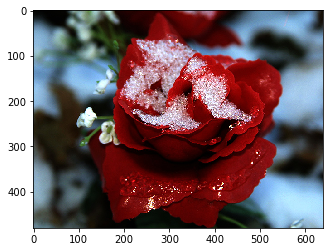

In [5]:
print_image(image)

## Ke Contrast
The constrast is based on the calculation of the aggregated RGB histogram of the image.

In [6]:
channels = cv2.split(image)
colors = ('r', 'g', 'b')

In [7]:
histogram = [0.0]
for (channel, color) in zip(channels, colors):
    histogram += cv2.calcHist([channel], [0], None, [256], [0, 256])

normalized_histogram = normalize(histogram, norm='l1', axis=0, copy=True, return_norm=False)

Then the width of 98% mass is calculated

In [8]:
def middleMassWidth(percentage, histogram):
    bias = (int)((1 - percentage)/2)
    accumulator = 0.0
    start = 0
    for index, bin_value in enumerate(histogram):
        accumulator = accumulator + bin_value
        if(accumulator < bias):
            start = index
        if(accumulator > bias + percentage):
            return index - start - 1

In [9]:
middleMassWidth(0.98, normalized_histogram)

243

In [10]:
middleMassWidth(0.95, normalized_histogram)

220

# Ke brightness
The mean brightness may be calculated as the mean of the value channel of the HSV representation of the image.

In [11]:
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv_image)

In [12]:
print(v)

[[ 20  16  13 ...,  25  22  18]
 [ 19  16  13 ...,  22  20  18]
 [ 19  15  12 ...,  20  19  19]
 ..., 
 [147 145 143 ..., 222 223 224]
 [147 148 148 ..., 220 221 221]
 [147 151 152 ..., 217 217 218]]


The value channel ranges from 0 to 255. So, to get the brightness average percentage of the image we can use.

In [13]:
np.mean(v) / 256 * 100

45.488103230794266

# Hue Count

In [14]:
hue_countable = []
for rows in hsv_image:
    for cols in rows:
        if cols[2]/256 > 0.15 and cols[2]/256 < 0.95 and cols[1]/256 > 0.2:
            hue_countable.append(cols[0])


In [15]:
print(len(hue_countable))

208675


In [16]:
hue_count_histogram = np.histogram(hue_countable, bins=20)

In [17]:
print(hue_count_histogram)

(array([84006,  4069,  3010,   825,  1440,  2499,  1011,  1189,  1860,
        2913, 10355, 60903,  2174,   312,   285,   315,   308,   957,
        3451, 26793], dtype=int64), array([   0.  ,    8.95,   17.9 ,   26.85,   35.8 ,   44.75,   53.7 ,
         62.65,   71.6 ,   80.55,   89.5 ,   98.45,  107.4 ,  116.35,
        125.3 ,  134.25,  143.2 ,  152.15,  161.1 ,  170.05,  179.  ]))


In [18]:
m = np.max(hue_count_histogram[0])
alpha = 0.05

In [19]:
N = 0
for bin in hue_count_histogram[0]:
    if bin > alpha * m:
        N = N + 1
print(N)

4


In [20]:
qh = 20 - N
print(qh)

16


# Spacial distribution of edges

In [21]:
laplacian = np.array([ [0.2/1.2, 0.8/1.2, 0.2/1.2],
                       [0.8/1.2, -4/1.2, 0.8/1.2],
                       [0.2/1.2, 0.8/1.2, 0.2/1.2]])
print(laplacian)

[[ 0.16666667  0.66666667  0.16666667]
 [ 0.66666667 -3.33333333  0.66666667]
 [ 0.16666667  0.66666667  0.16666667]]


In [22]:
r, g, b = cv2.split(image)
print(r)

[[ 19  15  10 ...,  14  11   7]
 [ 18  13  10 ...,  11   9   7]
 [ 15  12   9 ...,   9   8   8]
 ..., 
 [147 145 143 ..., 222 223 224]
 [147 148 148 ..., 220 221 221]
 [147 151 152 ..., 217 217 218]]


In [37]:
r_laplacian = np.absolute(signal.convolve2d(r, laplacian, mode='same', boundary='fill', fillvalue=0))
g_laplacian = np.absolute(signal.convolve2d(g, laplacian, mode='same', boundary='fill', fillvalue=0))
b_laplacian = np.absolute(signal.convolve2d(b, laplacian, mode='same', boundary='fill', fillvalue=0))

mean_laplacian = np.mean([r_laplacian, g_laplacian, b_laplacian], axis=0)
mean_laplacian = mean_laplacian / mean_laplacian.max() * 255
print(np.max(mean_laplacian))

255.0


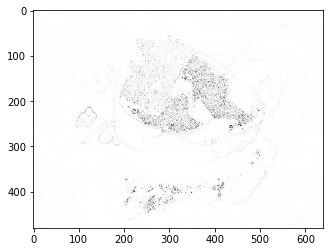

In [38]:
plt.imshow(mean_laplacian, cmap='gray_r')
plt.show()

In [58]:
resized_laplacian_image = sp.misc.imresize(mean_laplacian, [100, 100], interp='lanczos')
resized_laplacian_image = skimage.img_as_float(resized_laplacian_image)
normalize(resized_laplacian_image, norm='l1', axis=1, copy=False, return_norm=False)
resized_laplacian_image = resized_laplacian_image/100

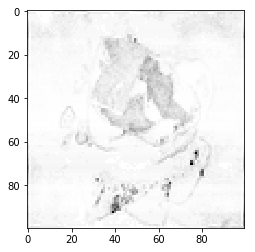

In [59]:
plt.imshow(resized_laplacian_image, cmap='gray_r')
plt.show()

## Edges bounding box area

In [60]:
Px = np.sum(mean_normalized_laplacian, axis=0)
Py = np.sum(mean_normalized_laplacian, axis=1)

In [61]:
print(Px)

[ 0.02461021  0.00334898  0.00674145  0.00563898  0.00546933  0.0052436
  0.00492149  0.00405244  0.00408709  0.00416098  0.0044265   0.00476653
  0.00494452  0.00484757  0.00472183  0.00590142  0.00657239  0.00693935
  0.00610754  0.00620974  0.00556357  0.00504876  0.00561356  0.00590473
  0.00509431  0.00538976  0.0060913   0.00806699  0.00750745  0.00660128
  0.00616671  0.00812474  0.01092142  0.00947406  0.01192454  0.01230309
  0.01234678  0.01412535  0.0158816   0.01898742  0.0196987   0.01830771
  0.01335711  0.01269827  0.01554646  0.01514118  0.0150076   0.01642354
  0.01692542  0.01581706  0.01402382  0.01276499  0.01481251  0.01393842
  0.01442146  0.01770967  0.01649817  0.01406233  0.01385243  0.01442605
  0.01310022  0.01446323  0.01489829  0.01489612  0.01789775  0.01597876
  0.0131203   0.01165586  0.01175687  0.00979974  0.01018676  0.01054699
  0.01038357  0.00910997  0.00820338  0.01233529  0.01012183  0.01291018
  0.01010578  0.00910326  0.01023439  0.00723033  0.

In [62]:
quality = 1 - middleMassWidth(0.98, Px) * middleMassWidth(0.98, Py)/10000
print("quality: ", quality)

quality:  0.05920000000000003


# Blur

In [110]:
fft_r = np.fft.fft2(r)
fft_g = np.fft.fft2(g)
fft_b = np.fft.fft2(b)

fft = np.mean([fft_r, fft_g, fft_b], axis=0)

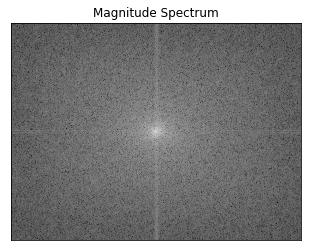

In [111]:
fshift = np.fft.fftshift(fft)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.plot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

In [112]:
np.abs(magnitude_spectrum).max()

(np.sum(np.abs(fft) > 5, axis=None)) / (len(fft) * len(fft[0]))

1.0